In [ ]:
# For colab users
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/My Drive/capstone

/content/drive/My Drive/capstone


In [ ]:
!pip install python-Levenshtein

In [ ]:
import model as m

import argparse
import os
import time

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.nn.utils import clip_grad_norm
import torchtext.data as data
import random
import matplotlib.pyplot as plt
from tqdm import notebook
from sklearn.model_selection import KFold

### train function

In [ ]:
def train(config, train_iter, model, criterion, optimizer, epoch, dic, save_path, prob=0):
    global iteration, n_total, train_loss, n_bad_loss
    global init, best_val_loss, stop

    print("=> EPOCH {}".format(epoch))
    train_iter.init_epoch()
    for i, batch in notebook.tqdm(enumerate(train_iter), total=len(train_iter)):
        # TODO 
        # add noise to batch
        g = batch.grapheme
        # if random.random() > prob:
         #   g = grapheme_add_noise(0.1, g, dic)
        
        
        iteration += 1
        model.train()
        output, _, __ = model(g, batch.phoneme[:-1].detach())
        target = batch.phoneme[1:]
        # print(output.size())
        loss = criterion(output.view(output.size(0) * output.size(1), -1),
                         target.view(target.size(0) * target.size(1)))
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.clip, 'inf')
        optimizer.step()
        
        n_total += batch.batch_size
        train_loss += loss.data * batch.batch_size
        
        # print("   % Time: {:5.0f} | Iteration: {:5} | Batch: {:4}/{}"
        #           " | Train loss: {:.4f}"
        #           .format(time.time()-init, iteration, train_iter.iterations,
        #                   len(train_iter), train_loss))
        
        if iteration % config.log_every == 0:
            train_loss /= n_total
            val_loss = validate(val_iter, model, criterion)
            print("   % Time: {:5.0f} | Iteration: {:5} | Batch: {:4}/{}"
                  " | Train loss: {:.4f} | Val loss: {:.4f}"
                  .format(time.time()-init, iteration, train_iter.iterations,
                          len(train_iter), train_loss, val_loss))
            
            # test for val_loss improvement
            n_total = train_loss = 0
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                n_bad_loss = 0
                torch.save(model.state_dict(), save_path)
            else:
                n_bad_loss += 1
            if n_bad_loss == config.n_bad_loss:
                best_val_loss = val_loss
                n_bad_loss = 0
                m.adjust_learning_rate(optimizer, config.lr_decay)
                new_lr = optimizer.param_groups[0]['lr']
                print("=> Adjust learning rate to: {}".format(new_lr))
                if new_lr < config.lr_min:
                    stop = True
                    break

### Validation Function

In [ ]:
def validate(val_iter, model, criterion):
    model.eval()
    val_loss = 0
    val_iter.init_epoch()
    for batch in val_iter:
        output, _, __ = model(batch.grapheme, batch.phoneme[:-1])
        target = batch.phoneme[1:]
        loss = criterion(output.squeeze(1), target.squeeze(1))
        val_loss += loss.data * batch.batch_size
    
    return val_loss / len(val_iter.dataset)

### Test Function

In [ ]:
def test(test_iter, model, g_dic, p_dic, print_error=False):
    model.eval()
    test_iter.init_epoch()
    test_per = 0
    wrong = []
    with torch.no_grad():
        for batch in test_iter:
            output = model(batch.grapheme).data.tolist()
            target = batch.phoneme[1:].squeeze(1).data.tolist()
            # calculate per, wer here
            try:
                per = m.phoneme_error_rate(output[:output.index(3) + 1], target)
            except ValueError:
                per = m.phoneme_error_rate(output, target) 

            if per > 0:
                
                tmp = list([g_dic[g] for g in batch.grapheme])
                tmp.reverse()
                wrong.append(tmp)

                if print_error:        
                    print("Grapheme: {}\nTarget: {}\nPrediction: {}\n".format(
                      ''.join(tmp),
                      ' '.join([p_dic[p] for p in target]),
                      ' '.join([p_dic[p] for p in output])))

            test_per += per  # batch_size = 1
        
        test_per = test_per / len(test_iter.dataset) * 100
        print("Phoneme error rate (PER): {:.2f}\n"
              .format(test_per))
    
    return test_per, wrong

In [ ]:
def print_result(model, lines, grapheme, g_dic, p_dic):
    g = grapheme[:-3]
    for line in lines:
        if line.strip().split()[0] == g:
            target = line.strip().split()[1:]

    input = [2]
    for letter in g:
        input.insert(1, g_dic.index(letter))
    input = torch.unsqueeze(torch.LongTensor(input).to("cuda"), 1)
    
    with torch.no_grad():

        output = model(input).data.tolist()

     
    print("Grapheme: {}\nTarget: {}\nPrediction: {}\n".format(
            g, ' '.join(target), ' '.join([p_dic[p] for p in output[:-1]]) ) )

## Set parameter

In [ ]:
parser = {
    'num_row': -1, # modify num_row to -1 if you want to input all data points
    'epochs': 15,
    'batch_size': 128,
    'max_len': 20,  # max length of grapheme/phoneme sequences
    'beam_size': 5,  # size of beam for beam-search
    'd_embed': 30,  # embedding dimension
    'd_hidden': 32,  # hidden dimension
    'attention': True,  # use attention or not
    'log_every': 100,  # number of iterations to log and validate training
    'lr': 0.007,  # initial learning rate
    'lr_decay': 0.5,  # decay lr when not observing improvement in val_loss
    'lr_min': 5e-4,  # stop when lr is too low
    'n_bad_loss': 5,  # number of bad val_loss before decaying
    'clip': 2.3,  # clip gradient, to avoid exploding gradient
    'cuda': True,  # using gpu or not
    'seed': 1234,  # initial seed
}
args = argparse.Namespace(**parser)

In [ ]:
args.cuda = args.cuda and torch.cuda.is_available()

# if not os.path.isdir(args.intermediate_path):
#     os.makedirs(args.intermediate_path)
# if not os.path.isdir(args.data_path):
#     os.makedirs(args.data_path)
#     URL = "https://github.com/cmusphinx/cmudict/archive/master.zip"
#     !wget $URL -O ./data/cmudict.zip
#     !unzip ./data/cmudict.zip -d ./data/
#     !mv ./data/cmudict-master $args.data_path

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

## split the data and build dataloader

In [ ]:
import pandas as pd
import pickle
from sklearn import model_selection

In [ ]:
df = pd.read_csv("filtered_no_stress_freq.csv", index_col=0)

In [ ]:
df.head()

,word,frequency
0,'bout B AW T\n,1
1,'em AH M\n,41
2,'round R AW N D\n,5
3,'tis T IH Z\n,2
4,a AH\n,23195


In [ ]:
kf = KFold(n_splits=10)

In [ ]:
new_df = df.sample(frac=1, random_state=777)
kf.get_n_splits(new_df)

10

In [ ]:
new_df.head()

,word,frequency
11153,fame F EY M\n,18
8225,derived D ER AY V D\n,39
21291,orthodontist AO R TH AH D AA N T AH S T\n,9
14817,humanities HH Y UW M AE N IH T IY Z\n,2
26477,sausage S AO S AH JH\n,1


In [ ]:
# please rerun this line if you need to retrain the model!!!
cv_generator = kf.split(new_df)

In [ ]:
e = 1
test_pers = []
for train_index, test_index in cv_generator:
    # data preparation
    print("data preparation for epoch " + str(e))
    train_set, val_set = model_selection.train_test_split(new_df.iloc[train_index,], test_size=0.2222, random_state=args.seed)
    test_set = new_df.iloc[test_index,]
    weight = np.clip(train_set["frequency"].tolist(), 0, 1000)
    np.random.seed(args.seed)
    train_lines = np.random.choice(train_set["word"].tolist(), size=100000, p=(np.array(weight) / sum(weight)) )
    val_lines = val_set["word"].tolist()
    test_lines = test_set["word"].tolist()
    train_iter, val_iter, test_iter, g_field, p_field = m.prepare_data(train_lines, val_lines, test_lines, args)
    dic = g_field.vocab.itos

    # Training
    #set up configuration
    print("Training for epoch " + str(e))
    config = args
    config.g_size = len(g_field.vocab)
    config.p_size = len(p_field.vocab)
    config.d_hidden = 32
    save_path = "model_para/cv_" + str(config.d_hidden) + "/best_model_" + str(config.d_hidden) + "_fold_" + str(e) + ".pt"
    
    model = m.G2P(config)
    criterion = nn.NLLLoss()
    if config.cuda:
        model.cuda()
        criterion.cuda()
    optimizer = optim.Adam(model.parameters(), lr=config.lr)  # use Adagrad
    
    # training
    iteration = n_total = train_loss = n_bad_loss = 0
    stop = False
    best_val_loss = 10
    init = time.time()

    # If you want to change epoch, uncomment the following line
    # config.epochs = 10

    for epoch in range(1, config.epochs+1):
        train(config, train_iter, model, criterion, optimizer, epoch, dic, save_path)
        if stop:
            break

    #calculate result
    test_per, mis_classified = test(test_iter, model, g_dic=g_field.vocab.itos, p_dic=p_field.vocab.itos)
    test_pers.append(test_per)

    # update epoch
    e = e + 1

data preparation for epoch 1
Training for epoch 1
=> EPOCH 1


   % Time:    28 | Iteration:   100 | Batch:  100/782 | Train loss: 1.5033 | Val loss: 2.7545
   % Time:    55 | Iteration:   200 | Batch:  200/782 | Train loss: 0.8713 | Val loss: 1.9619
   % Time:    83 | Iteration:   300 | Batch:  300/782 | Train loss: 0.4823 | Val loss: 1.3631
   % Time:   111 | Iteration:   400 | Batch:  400/782 | Train loss: 0.3128 | Val loss: 0.9982
   % Time:   138 | Iteration:   500 | Batch:  500/782 | Train loss: 0.2294 | Val loss: 0.8859
   % Time:   166 | Iteration:   600 | Batch:  600/782 | Train loss: 0.1953 | Val loss: 0.8003
   % Time:   194 | Iteration:   700 | Batch:  700/782 | Train loss: 0.1644 | Val loss: 0.7128

=> EPOCH 2


   % Time:   223 | Iteration:   800 | Batch:   18/782 | Train loss: 0.1405 | Val loss: 0.7184
   % Time:   251 | Iteration:   900 | Batch:  118/782 | Train loss: 0.1282 | Val loss: 0.7041
   % Time:   279 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.1173 | Val loss: 0.7167
   % Time:   307 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.1136 | Val loss: 0.6677
   % Time:   336 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.1105 | Val loss: 0.6658
   % Time:   364 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.1048 | Val loss: 0.6680
   % Time:   393 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.1001 | Val loss: 0.6417
   % Time:   421 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0962 | Val loss: 0.6373

=> EPOCH 3


   % Time:   449 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0900 | Val loss: 0.6346
   % Time:   476 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0833 | Val loss: 0.6235
   % Time:   504 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0836 | Val loss: 0.6261
   % Time:   532 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0808 | Val loss: 0.6279
   % Time:   559 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0762 | Val loss: 0.6385
   % Time:   587 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0786 | Val loss: 0.6257
   % Time:   615 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0810 | Val loss: 0.6278
=> Adjust learning rate to: 0.0035
   % Time:   643 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0676 | Val loss: 0.6012

=> EPOCH 4


   % Time:   671 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0609 | Val loss: 0.5955
   % Time:   699 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0573 | Val loss: 0.5880
   % Time:   727 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0592 | Val loss: 0.5972
   % Time:   755 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0558 | Val loss: 0.6047
   % Time:   782 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0579 | Val loss: 0.5907
   % Time:   810 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0547 | Val loss: 0.6061
   % Time:   838 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0527 | Val loss: 0.5969
=> Adjust learning rate to: 0.00175
   % Time:   865 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0558 | Val loss: 0.5845

=> EPOCH 5


   % Time:   893 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0493 | Val loss: 0.5886
   % Time:   921 | Iteration:  3300 | Batch:  172/782 | Train loss: 0.0480 | Val loss: 0.5851
   % Time:   948 | Iteration:  3400 | Batch:  272/782 | Train loss: 0.0480 | Val loss: 0.5837
   % Time:   976 | Iteration:  3500 | Batch:  372/782 | Train loss: 0.0469 | Val loss: 0.5934
   % Time:  1003 | Iteration:  3600 | Batch:  472/782 | Train loss: 0.0465 | Val loss: 0.5949
   % Time:  1031 | Iteration:  3700 | Batch:  572/782 | Train loss: 0.0465 | Val loss: 0.6051
   % Time:  1058 | Iteration:  3800 | Batch:  672/782 | Train loss: 0.0498 | Val loss: 0.5955
   % Time:  1085 | Iteration:  3900 | Batch:  772/782 | Train loss: 0.0456 | Val loss: 0.5922
=> Adjust learning rate to: 0.000875

=> EPOCH 6


   % Time:  1113 | Iteration:  4000 | Batch:   90/782 | Train loss: 0.0439 | Val loss: 0.5854
   % Time:  1141 | Iteration:  4100 | Batch:  190/782 | Train loss: 0.0434 | Val loss: 0.5885
   % Time:  1168 | Iteration:  4200 | Batch:  290/782 | Train loss: 0.0420 | Val loss: 0.6008
   % Time:  1196 | Iteration:  4300 | Batch:  390/782 | Train loss: 0.0424 | Val loss: 0.5932
   % Time:  1223 | Iteration:  4400 | Batch:  490/782 | Train loss: 0.0404 | Val loss: 0.5976
   % Time:  1250 | Iteration:  4500 | Batch:  590/782 | Train loss: 0.0434 | Val loss: 0.5907
=> Adjust learning rate to: 0.0004375
Phoneme error rate (PER): 16.68

data preparation for epoch 2
Training for epoch 2
=> EPOCH 1


   % Time:    27 | Iteration:   100 | Batch:  100/782 | Train loss: 1.4907 | Val loss: 2.7779
   % Time:    54 | Iteration:   200 | Batch:  200/782 | Train loss: 0.9744 | Val loss: 2.2686
   % Time:    81 | Iteration:   300 | Batch:  300/782 | Train loss: 0.5900 | Val loss: 1.4226
   % Time:   109 | Iteration:   400 | Batch:  400/782 | Train loss: 0.3556 | Val loss: 1.1101
   % Time:   136 | Iteration:   500 | Batch:  500/782 | Train loss: 0.2593 | Val loss: 0.9306
   % Time:   163 | Iteration:   600 | Batch:  600/782 | Train loss: 0.2083 | Val loss: 0.8264
   % Time:   191 | Iteration:   700 | Batch:  700/782 | Train loss: 0.1776 | Val loss: 0.7697

=> EPOCH 2


   % Time:   218 | Iteration:   800 | Batch:   18/782 | Train loss: 0.1595 | Val loss: 0.7216
   % Time:   245 | Iteration:   900 | Batch:  118/782 | Train loss: 0.1350 | Val loss: 0.7015
   % Time:   273 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.1295 | Val loss: 0.7088
   % Time:   300 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.1165 | Val loss: 0.6865
   % Time:   327 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.1140 | Val loss: 0.6715
   % Time:   355 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.1101 | Val loss: 0.6741
   % Time:   382 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.1014 | Val loss: 0.6435
   % Time:   409 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0963 | Val loss: 0.6382

=> EPOCH 3


   % Time:   437 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0935 | Val loss: 0.6419
   % Time:   464 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0858 | Val loss: 0.6363
   % Time:   491 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0842 | Val loss: 0.6344
   % Time:   518 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0853 | Val loss: 0.6205
   % Time:   545 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0817 | Val loss: 0.6375
   % Time:   573 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0791 | Val loss: 0.6370
   % Time:   600 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0769 | Val loss: 0.6691
   % Time:   627 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0730 | Val loss: 0.6435

=> EPOCH 4


   % Time:   654 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0719 | Val loss: 0.6127
   % Time:   681 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0682 | Val loss: 0.6405
   % Time:   709 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0691 | Val loss: 0.6302
   % Time:   736 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0687 | Val loss: 0.6199
   % Time:   763 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0702 | Val loss: 0.6519
   % Time:   790 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0685 | Val loss: 0.6153
=> Adjust learning rate to: 0.0035
   % Time:   817 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0586 | Val loss: 0.5840
   % Time:   844 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0559 | Val loss: 0.6001

=> EPOCH 5


   % Time:   872 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0521 | Val loss: 0.5972
   % Time:   899 | Iteration:  3300 | Batch:  172/782 | Train loss: 0.0519 | Val loss: 0.5987
   % Time:   926 | Iteration:  3400 | Batch:  272/782 | Train loss: 0.0515 | Val loss: 0.5867
   % Time:   954 | Iteration:  3500 | Batch:  372/782 | Train loss: 0.0483 | Val loss: 0.5944
=> Adjust learning rate to: 0.00175
   % Time:   981 | Iteration:  3600 | Batch:  472/782 | Train loss: 0.0484 | Val loss: 0.5837
   % Time:  1008 | Iteration:  3700 | Batch:  572/782 | Train loss: 0.0447 | Val loss: 0.6000
   % Time:  1035 | Iteration:  3800 | Batch:  672/782 | Train loss: 0.0468 | Val loss: 0.5873
   % Time:  1062 | Iteration:  3900 | Batch:  772/782 | Train loss: 0.0435 | Val loss: 0.5701

=> EPOCH 6


   % Time:  1090 | Iteration:  4000 | Batch:   90/782 | Train loss: 0.0417 | Val loss: 0.5872
   % Time:  1117 | Iteration:  4100 | Batch:  190/782 | Train loss: 0.0414 | Val loss: 0.5998
   % Time:  1144 | Iteration:  4200 | Batch:  290/782 | Train loss: 0.0449 | Val loss: 0.5962
   % Time:  1172 | Iteration:  4300 | Batch:  390/782 | Train loss: 0.0432 | Val loss: 0.5883
   % Time:  1199 | Iteration:  4400 | Batch:  490/782 | Train loss: 0.0437 | Val loss: 0.5858
=> Adjust learning rate to: 0.000875
   % Time:  1226 | Iteration:  4500 | Batch:  590/782 | Train loss: 0.0418 | Val loss: 0.5896
   % Time:  1253 | Iteration:  4600 | Batch:  690/782 | Train loss: 0.0413 | Val loss: 0.5795

=> EPOCH 7


   % Time:  1281 | Iteration:  4700 | Batch:    8/782 | Train loss: 0.0402 | Val loss: 0.5853
   % Time:  1308 | Iteration:  4800 | Batch:  108/782 | Train loss: 0.0387 | Val loss: 0.5865
   % Time:  1335 | Iteration:  4900 | Batch:  208/782 | Train loss: 0.0392 | Val loss: 0.5882
   % Time:  1363 | Iteration:  5000 | Batch:  308/782 | Train loss: 0.0373 | Val loss: 0.5906
   % Time:  1390 | Iteration:  5100 | Batch:  408/782 | Train loss: 0.0377 | Val loss: 0.5932
=> Adjust learning rate to: 0.0004375
Phoneme error rate (PER): 16.63

data preparation for epoch 3
Training for epoch 3
=> EPOCH 1


   % Time:    27 | Iteration:   100 | Batch:  100/782 | Train loss: 1.4764 | Val loss: 2.7741
   % Time:    55 | Iteration:   200 | Batch:  200/782 | Train loss: 0.8712 | Val loss: 2.0177
   % Time:    82 | Iteration:   300 | Batch:  300/782 | Train loss: 0.4849 | Val loss: 1.5877
   % Time:   109 | Iteration:   400 | Batch:  400/782 | Train loss: 0.3419 | Val loss: 1.2348
   % Time:   136 | Iteration:   500 | Batch:  500/782 | Train loss: 0.2516 | Val loss: 0.9970
   % Time:   163 | Iteration:   600 | Batch:  600/782 | Train loss: 0.1970 | Val loss: 0.9477
   % Time:   190 | Iteration:   700 | Batch:  700/782 | Train loss: 0.1727 | Val loss: 0.8986

=> EPOCH 2


   % Time:   217 | Iteration:   800 | Batch:   18/782 | Train loss: 0.1519 | Val loss: 0.8921
   % Time:   244 | Iteration:   900 | Batch:  118/782 | Train loss: 0.1353 | Val loss: 0.8421
   % Time:   271 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.1219 | Val loss: 0.8064
   % Time:   298 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.1126 | Val loss: 0.8126
   % Time:   325 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.1031 | Val loss: 0.8132
   % Time:   352 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.1011 | Val loss: 0.7791
   % Time:   379 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.0962 | Val loss: 0.8193
   % Time:   406 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0932 | Val loss: 0.7931

=> EPOCH 3


   % Time:   433 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0926 | Val loss: 0.7824
   % Time:   460 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0849 | Val loss: 0.7505
   % Time:   487 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0816 | Val loss: 0.7643
   % Time:   514 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0828 | Val loss: 0.7978
   % Time:   541 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0766 | Val loss: 0.7436
   % Time:   569 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0775 | Val loss: 0.7654
   % Time:   596 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0751 | Val loss: 0.7710
   % Time:   623 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0736 | Val loss: 0.7738

=> EPOCH 4


   % Time:   651 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0734 | Val loss: 0.7735
   % Time:   678 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0673 | Val loss: 0.7437
=> Adjust learning rate to: 0.0035
   % Time:   706 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0606 | Val loss: 0.7691
   % Time:   734 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0559 | Val loss: 0.7332
   % Time:   762 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0572 | Val loss: 0.7151
   % Time:   791 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0551 | Val loss: 0.7336
   % Time:   819 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0547 | Val loss: 0.7352
   % Time:   848 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0549 | Val loss: 0.7355

=> EPOCH 5


   % Time:   876 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0533 | Val loss: 0.7365
   % Time:   904 | Iteration:  3300 | Batch:  172/782 | Train loss: 0.0526 | Val loss: 0.7394
=> Adjust learning rate to: 0.00175
   % Time:   932 | Iteration:  3400 | Batch:  272/782 | Train loss: 0.0487 | Val loss: 0.7217
   % Time:   961 | Iteration:  3500 | Batch:  372/782 | Train loss: 0.0490 | Val loss: 0.7128
   % Time:   989 | Iteration:  3600 | Batch:  472/782 | Train loss: 0.0444 | Val loss: 0.7362
   % Time:  1017 | Iteration:  3700 | Batch:  572/782 | Train loss: 0.0435 | Val loss: 0.7368
   % Time:  1045 | Iteration:  3800 | Batch:  672/782 | Train loss: 0.0454 | Val loss: 0.7313
   % Time:  1073 | Iteration:  3900 | Batch:  772/782 | Train loss: 0.0458 | Val loss: 0.7335

=> EPOCH 6


   % Time:  1101 | Iteration:  4000 | Batch:   90/782 | Train loss: 0.0439 | Val loss: 0.7530
=> Adjust learning rate to: 0.000875
   % Time:  1129 | Iteration:  4100 | Batch:  190/782 | Train loss: 0.0425 | Val loss: 0.7250
   % Time:  1156 | Iteration:  4200 | Batch:  290/782 | Train loss: 0.0415 | Val loss: 0.7387
   % Time:  1184 | Iteration:  4300 | Batch:  390/782 | Train loss: 0.0393 | Val loss: 0.7294
   % Time:  1211 | Iteration:  4400 | Batch:  490/782 | Train loss: 0.0430 | Val loss: 0.7359
   % Time:  1239 | Iteration:  4500 | Batch:  590/782 | Train loss: 0.0451 | Val loss: 0.7384
   % Time:  1266 | Iteration:  4600 | Batch:  690/782 | Train loss: 0.0417 | Val loss: 0.7406
=> Adjust learning rate to: 0.0004375
Phoneme error rate (PER): 21.28

data preparation for epoch 4
Training for epoch 4
=> EPOCH 1


   % Time:    28 | Iteration:   100 | Batch:  100/782 | Train loss: 1.4904 | Val loss: 2.7273
   % Time:    56 | Iteration:   200 | Batch:  200/782 | Train loss: 0.9224 | Val loss: 1.7866
   % Time:    83 | Iteration:   300 | Batch:  300/782 | Train loss: 0.4720 | Val loss: 1.1088
   % Time:   112 | Iteration:   400 | Batch:  400/782 | Train loss: 0.2822 | Val loss: 0.8491
   % Time:   141 | Iteration:   500 | Batch:  500/782 | Train loss: 0.2107 | Val loss: 0.7840
   % Time:   169 | Iteration:   600 | Batch:  600/782 | Train loss: 0.1762 | Val loss: 0.6754
   % Time:   197 | Iteration:   700 | Batch:  700/782 | Train loss: 0.1487 | Val loss: 0.6696

=> EPOCH 2


   % Time:   225 | Iteration:   800 | Batch:   18/782 | Train loss: 0.1314 | Val loss: 0.6333
   % Time:   253 | Iteration:   900 | Batch:  118/782 | Train loss: 0.1198 | Val loss: 0.6314
   % Time:   280 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.1104 | Val loss: 0.6255
   % Time:   308 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.1050 | Val loss: 0.6192
   % Time:   336 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.0957 | Val loss: 0.6071
   % Time:   364 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.0951 | Val loss: 0.5869
   % Time:   391 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.0911 | Val loss: 0.5858
   % Time:   419 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0892 | Val loss: 0.5655

=> EPOCH 3


   % Time:   447 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0878 | Val loss: 0.5902
   % Time:   475 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0780 | Val loss: 0.5709
   % Time:   502 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0773 | Val loss: 0.5772
   % Time:   530 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0756 | Val loss: 0.6084
   % Time:   558 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0731 | Val loss: 0.5493
   % Time:   586 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0701 | Val loss: 0.5404
   % Time:   614 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0740 | Val loss: 0.5221
   % Time:   641 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0694 | Val loss: 0.5234

=> EPOCH 4


   % Time:   669 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0651 | Val loss: 0.5196
   % Time:   696 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0639 | Val loss: 0.5553
   % Time:   724 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0625 | Val loss: 0.5497
   % Time:   751 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0639 | Val loss: 0.5462
   % Time:   779 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0603 | Val loss: 0.5406
   % Time:   806 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0630 | Val loss: 0.5351
=> Adjust learning rate to: 0.0035
   % Time:   833 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0538 | Val loss: 0.5201
   % Time:   861 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0524 | Val loss: 0.5092

=> EPOCH 5


   % Time:   889 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0482 | Val loss: 0.5182
   % Time:   916 | Iteration:  3300 | Batch:  172/782 | Train loss: 0.0461 | Val loss: 0.5017
   % Time:   944 | Iteration:  3400 | Batch:  272/782 | Train loss: 0.0470 | Val loss: 0.5091
   % Time:   971 | Iteration:  3500 | Batch:  372/782 | Train loss: 0.0479 | Val loss: 0.5145
   % Time:   999 | Iteration:  3600 | Batch:  472/782 | Train loss: 0.0465 | Val loss: 0.5144
   % Time:  1026 | Iteration:  3700 | Batch:  572/782 | Train loss: 0.0436 | Val loss: 0.5292
   % Time:  1053 | Iteration:  3800 | Batch:  672/782 | Train loss: 0.0441 | Val loss: 0.5254
=> Adjust learning rate to: 0.00175
   % Time:  1080 | Iteration:  3900 | Batch:  772/782 | Train loss: 0.0447 | Val loss: 0.5162

=> EPOCH 6


   % Time:  1108 | Iteration:  4000 | Batch:   90/782 | Train loss: 0.0413 | Val loss: 0.5201
   % Time:  1136 | Iteration:  4100 | Batch:  190/782 | Train loss: 0.0397 | Val loss: 0.5131
   % Time:  1163 | Iteration:  4200 | Batch:  290/782 | Train loss: 0.0407 | Val loss: 0.5029
   % Time:  1191 | Iteration:  4300 | Batch:  390/782 | Train loss: 0.0385 | Val loss: 0.5134
   % Time:  1218 | Iteration:  4400 | Batch:  490/782 | Train loss: 0.0377 | Val loss: 0.5289
   % Time:  1245 | Iteration:  4500 | Batch:  590/782 | Train loss: 0.0375 | Val loss: 0.5314
   % Time:  1273 | Iteration:  4600 | Batch:  690/782 | Train loss: 0.0391 | Val loss: 0.5364

=> EPOCH 7


   % Time:  1300 | Iteration:  4700 | Batch:    8/782 | Train loss: 0.0377 | Val loss: 0.5357
=> Adjust learning rate to: 0.000875
   % Time:  1328 | Iteration:  4800 | Batch:  108/782 | Train loss: 0.0376 | Val loss: 0.5238
   % Time:  1355 | Iteration:  4900 | Batch:  208/782 | Train loss: 0.0357 | Val loss: 0.5312
   % Time:  1383 | Iteration:  5000 | Batch:  308/782 | Train loss: 0.0348 | Val loss: 0.5289
   % Time:  1410 | Iteration:  5100 | Batch:  408/782 | Train loss: 0.0336 | Val loss: 0.5258
   % Time:  1438 | Iteration:  5200 | Batch:  508/782 | Train loss: 0.0361 | Val loss: 0.5230
   % Time:  1465 | Iteration:  5300 | Batch:  608/782 | Train loss: 0.0341 | Val loss: 0.5204
   % Time:  1493 | Iteration:  5400 | Batch:  708/782 | Train loss: 0.0345 | Val loss: 0.5238

=> EPOCH 8


   % Time:  1520 | Iteration:  5500 | Batch:   26/782 | Train loss: 0.0354 | Val loss: 0.5166
   % Time:  1548 | Iteration:  5600 | Batch:  126/782 | Train loss: 0.0357 | Val loss: 0.5343
   % Time:  1575 | Iteration:  5700 | Batch:  226/782 | Train loss: 0.0341 | Val loss: 0.5334
   % Time:  1603 | Iteration:  5800 | Batch:  326/782 | Train loss: 0.0342 | Val loss: 0.5363
   % Time:  1631 | Iteration:  5900 | Batch:  426/782 | Train loss: 0.0337 | Val loss: 0.5288
   % Time:  1658 | Iteration:  6000 | Batch:  526/782 | Train loss: 0.0347 | Val loss: 0.5460
=> Adjust learning rate to: 0.0004375
Phoneme error rate (PER): 14.53

data preparation for epoch 5
Training for epoch 5
=> EPOCH 1


   % Time:    28 | Iteration:   100 | Batch:  100/782 | Train loss: 1.5009 | Val loss: 2.6561
   % Time:    56 | Iteration:   200 | Batch:  200/782 | Train loss: 0.8426 | Val loss: 1.8097
   % Time:    85 | Iteration:   300 | Batch:  300/782 | Train loss: 0.4277 | Val loss: 1.0856
   % Time:   113 | Iteration:   400 | Batch:  400/782 | Train loss: 0.2656 | Val loss: 0.8954
   % Time:   140 | Iteration:   500 | Batch:  500/782 | Train loss: 0.1997 | Val loss: 0.7709
   % Time:   168 | Iteration:   600 | Batch:  600/782 | Train loss: 0.1640 | Val loss: 0.7067
   % Time:   196 | Iteration:   700 | Batch:  700/782 | Train loss: 0.1418 | Val loss: 0.6542

=> EPOCH 2


   % Time:   224 | Iteration:   800 | Batch:   18/782 | Train loss: 0.1260 | Val loss: 0.6435
   % Time:   252 | Iteration:   900 | Batch:  118/782 | Train loss: 0.1098 | Val loss: 0.6090
   % Time:   279 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.1058 | Val loss: 0.6092
   % Time:   307 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.0960 | Val loss: 0.5916
   % Time:   334 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.0923 | Val loss: 0.5960
   % Time:   362 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.0881 | Val loss: 0.5742
   % Time:   390 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.0827 | Val loss: 0.5647
   % Time:   417 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0825 | Val loss: 0.5734

=> EPOCH 3


   % Time:   445 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0792 | Val loss: 0.5523
   % Time:   473 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0737 | Val loss: 0.5549
   % Time:   500 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0717 | Val loss: 0.5573
   % Time:   528 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0710 | Val loss: 0.5559
   % Time:   556 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0655 | Val loss: 0.5369
   % Time:   583 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0683 | Val loss: 0.5567
   % Time:   610 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0679 | Val loss: 0.5526
   % Time:   638 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0619 | Val loss: 0.5386

=> EPOCH 4


   % Time:   666 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0632 | Val loss: 0.5505
   % Time:   693 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0615 | Val loss: 0.5375
=> Adjust learning rate to: 0.0035
   % Time:   721 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0528 | Val loss: 0.5136
   % Time:   748 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0498 | Val loss: 0.5181
   % Time:   776 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0488 | Val loss: 0.5191
   % Time:   803 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0482 | Val loss: 0.5178
   % Time:   830 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0494 | Val loss: 0.5213
   % Time:   858 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0475 | Val loss: 0.5123

=> EPOCH 5


   % Time:   885 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0435 | Val loss: 0.5043
   % Time:   912 | Iteration:  3300 | Batch:  172/782 | Train loss: 0.0451 | Val loss: 0.5116
   % Time:   940 | Iteration:  3400 | Batch:  272/782 | Train loss: 0.0458 | Val loss: 0.5208
   % Time:   967 | Iteration:  3500 | Batch:  372/782 | Train loss: 0.0427 | Val loss: 0.5213
   % Time:   994 | Iteration:  3600 | Batch:  472/782 | Train loss: 0.0437 | Val loss: 0.5234
   % Time:  1021 | Iteration:  3700 | Batch:  572/782 | Train loss: 0.0444 | Val loss: 0.5292
=> Adjust learning rate to: 0.00175
   % Time:  1048 | Iteration:  3800 | Batch:  672/782 | Train loss: 0.0427 | Val loss: 0.5158
   % Time:  1076 | Iteration:  3900 | Batch:  772/782 | Train loss: 0.0397 | Val loss: 0.5119

=> EPOCH 6


   % Time:  1103 | Iteration:  4000 | Batch:   90/782 | Train loss: 0.0365 | Val loss: 0.5113
   % Time:  1131 | Iteration:  4100 | Batch:  190/782 | Train loss: 0.0350 | Val loss: 0.5232
   % Time:  1158 | Iteration:  4200 | Batch:  290/782 | Train loss: 0.0360 | Val loss: 0.5132
   % Time:  1185 | Iteration:  4300 | Batch:  390/782 | Train loss: 0.0358 | Val loss: 0.5289
   % Time:  1213 | Iteration:  4400 | Batch:  490/782 | Train loss: 0.0381 | Val loss: 0.5318
   % Time:  1240 | Iteration:  4500 | Batch:  590/782 | Train loss: 0.0368 | Val loss: 0.5210
=> Adjust learning rate to: 0.000875
   % Time:  1267 | Iteration:  4600 | Batch:  690/782 | Train loss: 0.0369 | Val loss: 0.5140

=> EPOCH 7


   % Time:  1295 | Iteration:  4700 | Batch:    8/782 | Train loss: 0.0358 | Val loss: 0.5240
   % Time:  1322 | Iteration:  4800 | Batch:  108/782 | Train loss: 0.0317 | Val loss: 0.5250
   % Time:  1349 | Iteration:  4900 | Batch:  208/782 | Train loss: 0.0341 | Val loss: 0.5222
   % Time:  1376 | Iteration:  5000 | Batch:  308/782 | Train loss: 0.0333 | Val loss: 0.5198
   % Time:  1403 | Iteration:  5100 | Batch:  408/782 | Train loss: 0.0321 | Val loss: 0.5162
=> Adjust learning rate to: 0.0004375
Phoneme error rate (PER): 14.67

data preparation for epoch 6
Training for epoch 6
=> EPOCH 1


   % Time:    28 | Iteration:   100 | Batch:  100/782 | Train loss: 1.5013 | Val loss: 2.7453
   % Time:    55 | Iteration:   200 | Batch:  200/782 | Train loss: 0.9211 | Val loss: 1.7805
   % Time:    82 | Iteration:   300 | Batch:  300/782 | Train loss: 0.4760 | Val loss: 1.0641
   % Time:   109 | Iteration:   400 | Batch:  400/782 | Train loss: 0.2862 | Val loss: 0.8461
   % Time:   136 | Iteration:   500 | Batch:  500/782 | Train loss: 0.2099 | Val loss: 0.6912
   % Time:   163 | Iteration:   600 | Batch:  600/782 | Train loss: 0.1653 | Val loss: 0.6668
   % Time:   190 | Iteration:   700 | Batch:  700/782 | Train loss: 0.1466 | Val loss: 0.5932

=> EPOCH 2


   % Time:   217 | Iteration:   800 | Batch:   18/782 | Train loss: 0.1256 | Val loss: 0.5993
   % Time:   244 | Iteration:   900 | Batch:  118/782 | Train loss: 0.1130 | Val loss: 0.6022
   % Time:   271 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.1064 | Val loss: 0.5867
   % Time:   298 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.0964 | Val loss: 0.5570
   % Time:   326 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.0955 | Val loss: 0.5718
   % Time:   353 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.0892 | Val loss: 0.5433
   % Time:   380 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.0893 | Val loss: 0.5359
   % Time:   408 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0837 | Val loss: 0.5273

=> EPOCH 3


   % Time:   435 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0818 | Val loss: 0.5275
   % Time:   462 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0730 | Val loss: 0.5251
   % Time:   489 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0732 | Val loss: 0.5241
   % Time:   516 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0745 | Val loss: 0.5225
   % Time:   543 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0726 | Val loss: 0.5165
   % Time:   570 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0689 | Val loss: 0.5438
   % Time:   597 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0711 | Val loss: 0.5106
   % Time:   624 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0674 | Val loss: 0.5086

=> EPOCH 4


   % Time:   651 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0655 | Val loss: 0.5152
   % Time:   678 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0611 | Val loss: 0.5309
   % Time:   706 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0631 | Val loss: 0.5301
   % Time:   733 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0613 | Val loss: 0.5247
   % Time:   760 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0613 | Val loss: 0.5257
=> Adjust learning rate to: 0.0035
   % Time:   787 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0541 | Val loss: 0.4875
   % Time:   814 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0487 | Val loss: 0.4815
   % Time:   841 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0477 | Val loss: 0.4933

=> EPOCH 5


   % Time:   868 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0460 | Val loss: 0.4942
   % Time:   895 | Iteration:  3300 | Batch:  172/782 | Train loss: 0.0438 | Val loss: 0.4956
   % Time:   922 | Iteration:  3400 | Batch:  272/782 | Train loss: 0.0470 | Val loss: 0.4953
   % Time:   949 | Iteration:  3500 | Batch:  372/782 | Train loss: 0.0449 | Val loss: 0.5046
=> Adjust learning rate to: 0.00175
   % Time:   977 | Iteration:  3600 | Batch:  472/782 | Train loss: 0.0414 | Val loss: 0.4996
   % Time:  1004 | Iteration:  3700 | Batch:  572/782 | Train loss: 0.0398 | Val loss: 0.4960
   % Time:  1031 | Iteration:  3800 | Batch:  672/782 | Train loss: 0.0412 | Val loss: 0.5047
   % Time:  1058 | Iteration:  3900 | Batch:  772/782 | Train loss: 0.0417 | Val loss: 0.4923

=> EPOCH 6


   % Time:  1085 | Iteration:  4000 | Batch:   90/782 | Train loss: 0.0375 | Val loss: 0.4931
   % Time:  1112 | Iteration:  4100 | Batch:  190/782 | Train loss: 0.0396 | Val loss: 0.4970
   % Time:  1139 | Iteration:  4200 | Batch:  290/782 | Train loss: 0.0387 | Val loss: 0.4895
   % Time:  1166 | Iteration:  4300 | Batch:  390/782 | Train loss: 0.0359 | Val loss: 0.5027
   % Time:  1193 | Iteration:  4400 | Batch:  490/782 | Train loss: 0.0378 | Val loss: 0.5081
   % Time:  1220 | Iteration:  4500 | Batch:  590/782 | Train loss: 0.0401 | Val loss: 0.5019
   % Time:  1247 | Iteration:  4600 | Batch:  690/782 | Train loss: 0.0370 | Val loss: 0.5079

=> EPOCH 7


   % Time:  1275 | Iteration:  4700 | Batch:    8/782 | Train loss: 0.0384 | Val loss: 0.5093
=> Adjust learning rate to: 0.000875
   % Time:  1302 | Iteration:  4800 | Batch:  108/782 | Train loss: 0.0344 | Val loss: 0.5021
   % Time:  1329 | Iteration:  4900 | Batch:  208/782 | Train loss: 0.0367 | Val loss: 0.4960
   % Time:  1356 | Iteration:  5000 | Batch:  308/782 | Train loss: 0.0337 | Val loss: 0.4986
   % Time:  1383 | Iteration:  5100 | Batch:  408/782 | Train loss: 0.0321 | Val loss: 0.4975
   % Time:  1410 | Iteration:  5200 | Batch:  508/782 | Train loss: 0.0339 | Val loss: 0.4985
   % Time:  1437 | Iteration:  5300 | Batch:  608/782 | Train loss: 0.0340 | Val loss: 0.5026
   % Time:  1464 | Iteration:  5400 | Batch:  708/782 | Train loss: 0.0343 | Val loss: 0.5034
=> Adjust learning rate to: 0.0004375
Phoneme error rate (PER): 13.98

data preparation for epoch 7
Training for epoch 7
=> EPOCH 1


   % Time:    27 | Iteration:   100 | Batch:  100/782 | Train loss: 1.4283 | Val loss: 2.8684
   % Time:    54 | Iteration:   200 | Batch:  200/782 | Train loss: 0.8717 | Val loss: 1.8310
   % Time:    81 | Iteration:   300 | Batch:  300/782 | Train loss: 0.4574 | Val loss: 1.2486
   % Time:   108 | Iteration:   400 | Batch:  400/782 | Train loss: 0.2856 | Val loss: 1.0132
   % Time:   135 | Iteration:   500 | Batch:  500/782 | Train loss: 0.2072 | Val loss: 0.8624
   % Time:   162 | Iteration:   600 | Batch:  600/782 | Train loss: 0.1704 | Val loss: 0.8715
   % Time:   189 | Iteration:   700 | Batch:  700/782 | Train loss: 0.1452 | Val loss: 0.7596

=> EPOCH 2


   % Time:   216 | Iteration:   800 | Batch:   18/782 | Train loss: 0.1315 | Val loss: 0.6731
   % Time:   243 | Iteration:   900 | Batch:  118/782 | Train loss: 0.1140 | Val loss: 0.6405
   % Time:   270 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.1103 | Val loss: 0.6507
   % Time:   297 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.1001 | Val loss: 0.6477
   % Time:   324 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.0941 | Val loss: 0.6093
   % Time:   351 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.0918 | Val loss: 0.6399
   % Time:   378 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.0882 | Val loss: 0.6491
   % Time:   405 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0832 | Val loss: 0.6223

=> EPOCH 3


   % Time:   433 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0819 | Val loss: 0.5954
   % Time:   460 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0750 | Val loss: 0.5993
   % Time:   487 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0733 | Val loss: 0.5891
   % Time:   514 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0754 | Val loss: 0.5961
   % Time:   541 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0725 | Val loss: 0.6032
   % Time:   568 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0736 | Val loss: 0.6027
   % Time:   595 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0683 | Val loss: 0.5864
   % Time:   623 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0673 | Val loss: 0.5974

=> EPOCH 4


   % Time:   651 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0664 | Val loss: 0.5724
   % Time:   678 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0647 | Val loss: 0.5759
   % Time:   706 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0646 | Val loss: 0.5826
   % Time:   733 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0614 | Val loss: 0.5934
   % Time:   760 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0587 | Val loss: 0.5899
   % Time:   788 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0603 | Val loss: 0.6113
=> Adjust learning rate to: 0.0035
   % Time:   815 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0526 | Val loss: 0.5729
   % Time:   842 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0508 | Val loss: 0.5606

=> EPOCH 5


   % Time:   870 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0464 | Val loss: 0.5593
   % Time:   897 | Iteration:  3300 | Batch:  172/782 | Train loss: 0.0455 | Val loss: 0.5721
   % Time:   924 | Iteration:  3400 | Batch:  272/782 | Train loss: 0.0468 | Val loss: 0.5902
   % Time:   952 | Iteration:  3500 | Batch:  372/782 | Train loss: 0.0466 | Val loss: 0.5874
   % Time:   979 | Iteration:  3600 | Batch:  472/782 | Train loss: 0.0443 | Val loss: 0.5885
   % Time:  1006 | Iteration:  3700 | Batch:  572/782 | Train loss: 0.0435 | Val loss: 0.5776
=> Adjust learning rate to: 0.00175
   % Time:  1034 | Iteration:  3800 | Batch:  672/782 | Train loss: 0.0431 | Val loss: 0.5612
   % Time:  1061 | Iteration:  3900 | Batch:  772/782 | Train loss: 0.0415 | Val loss: 0.5832

=> EPOCH 6


   % Time:  1088 | Iteration:  4000 | Batch:   90/782 | Train loss: 0.0380 | Val loss: 0.5818
   % Time:  1116 | Iteration:  4100 | Batch:  190/782 | Train loss: 0.0379 | Val loss: 0.5722
   % Time:  1143 | Iteration:  4200 | Batch:  290/782 | Train loss: 0.0367 | Val loss: 0.5813
   % Time:  1170 | Iteration:  4300 | Batch:  390/782 | Train loss: 0.0379 | Val loss: 0.5847
=> Adjust learning rate to: 0.000875
   % Time:  1197 | Iteration:  4400 | Batch:  490/782 | Train loss: 0.0385 | Val loss: 0.5732
   % Time:  1224 | Iteration:  4500 | Batch:  590/782 | Train loss: 0.0380 | Val loss: 0.5761
   % Time:  1251 | Iteration:  4600 | Batch:  690/782 | Train loss: 0.0361 | Val loss: 0.5757

=> EPOCH 7


   % Time:  1279 | Iteration:  4700 | Batch:    8/782 | Train loss: 0.0358 | Val loss: 0.5811
   % Time:  1306 | Iteration:  4800 | Batch:  108/782 | Train loss: 0.0357 | Val loss: 0.5783
   % Time:  1333 | Iteration:  4900 | Batch:  208/782 | Train loss: 0.0345 | Val loss: 0.5729
   % Time:  1361 | Iteration:  5000 | Batch:  308/782 | Train loss: 0.0368 | Val loss: 0.5866
   % Time:  1388 | Iteration:  5100 | Batch:  408/782 | Train loss: 0.0331 | Val loss: 0.5830
   % Time:  1415 | Iteration:  5200 | Batch:  508/782 | Train loss: 0.0340 | Val loss: 0.5832
   % Time:  1442 | Iteration:  5300 | Batch:  608/782 | Train loss: 0.0352 | Val loss: 0.5810
   % Time:  1470 | Iteration:  5400 | Batch:  708/782 | Train loss: 0.0340 | Val loss: 0.5841
=> Adjust learning rate to: 0.0004375
Phoneme error rate (PER): 16.64

data preparation for epoch 8
Training for epoch 8
=> EPOCH 1


   % Time:    28 | Iteration:   100 | Batch:  100/782 | Train loss: 1.4866 | Val loss: 2.8078
   % Time:    55 | Iteration:   200 | Batch:  200/782 | Train loss: 0.9311 | Val loss: 2.2088
   % Time:    83 | Iteration:   300 | Batch:  300/782 | Train loss: 0.5309 | Val loss: 1.3501
   % Time:   110 | Iteration:   400 | Batch:  400/782 | Train loss: 0.3284 | Val loss: 0.9979
   % Time:   138 | Iteration:   500 | Batch:  500/782 | Train loss: 0.2370 | Val loss: 0.8359
   % Time:   165 | Iteration:   600 | Batch:  600/782 | Train loss: 0.1934 | Val loss: 0.7810
   % Time:   193 | Iteration:   700 | Batch:  700/782 | Train loss: 0.1630 | Val loss: 0.7172

=> EPOCH 2


   % Time:   220 | Iteration:   800 | Batch:   18/782 | Train loss: 0.1438 | Val loss: 0.6692
   % Time:   247 | Iteration:   900 | Batch:  118/782 | Train loss: 0.1290 | Val loss: 0.6817
   % Time:   274 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.1172 | Val loss: 0.6517
   % Time:   302 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.1106 | Val loss: 0.6252
   % Time:   329 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.1015 | Val loss: 0.6056
   % Time:   356 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.0978 | Val loss: 0.6098
   % Time:   383 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.0967 | Val loss: 0.6095
   % Time:   410 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0935 | Val loss: 0.5756

=> EPOCH 3


   % Time:   437 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0823 | Val loss: 0.5804
   % Time:   464 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0785 | Val loss: 0.5911
   % Time:   491 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0819 | Val loss: 0.5780
   % Time:   518 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0787 | Val loss: 0.5727
   % Time:   546 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0771 | Val loss: 0.5779
   % Time:   574 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0760 | Val loss: 0.5785
   % Time:   601 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0709 | Val loss: 0.5535
   % Time:   628 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0713 | Val loss: 0.5752

=> EPOCH 4


   % Time:   656 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0709 | Val loss: 0.5698
   % Time:   685 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0647 | Val loss: 0.5630
   % Time:   714 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0644 | Val loss: 0.5890
   % Time:   743 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0645 | Val loss: 0.5728
=> Adjust learning rate to: 0.0035
   % Time:   772 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0577 | Val loss: 0.5424
   % Time:   801 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0519 | Val loss: 0.5428
   % Time:   829 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0508 | Val loss: 0.5380
   % Time:   858 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0527 | Val loss: 0.5317

=> EPOCH 5


   % Time:   887 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0503 | Val loss: 0.5494
   % Time:   915 | Iteration:  3300 | Batch:  172/782 | Train loss: 0.0495 | Val loss: 0.5451
   % Time:   944 | Iteration:  3400 | Batch:  272/782 | Train loss: 0.0509 | Val loss: 0.5416
   % Time:   973 | Iteration:  3500 | Batch:  372/782 | Train loss: 0.0484 | Val loss: 0.5611
   % Time:  1001 | Iteration:  3600 | Batch:  472/782 | Train loss: 0.0465 | Val loss: 0.5615
=> Adjust learning rate to: 0.00175
   % Time:  1030 | Iteration:  3700 | Batch:  572/782 | Train loss: 0.0448 | Val loss: 0.5383
   % Time:  1058 | Iteration:  3800 | Batch:  672/782 | Train loss: 0.0438 | Val loss: 0.5337
   % Time:  1087 | Iteration:  3900 | Batch:  772/782 | Train loss: 0.0413 | Val loss: 0.5412

=> EPOCH 6


   % Time:  1116 | Iteration:  4000 | Batch:   90/782 | Train loss: 0.0408 | Val loss: 0.5530
   % Time:  1144 | Iteration:  4100 | Batch:  190/782 | Train loss: 0.0417 | Val loss: 0.5461
   % Time:  1173 | Iteration:  4200 | Batch:  290/782 | Train loss: 0.0405 | Val loss: 0.5516
   % Time:  1202 | Iteration:  4300 | Batch:  390/782 | Train loss: 0.0409 | Val loss: 0.5443
=> Adjust learning rate to: 0.000875
   % Time:  1230 | Iteration:  4400 | Batch:  490/782 | Train loss: 0.0390 | Val loss: 0.5437
   % Time:  1258 | Iteration:  4500 | Batch:  590/782 | Train loss: 0.0401 | Val loss: 0.5365
   % Time:  1287 | Iteration:  4600 | Batch:  690/782 | Train loss: 0.0386 | Val loss: 0.5435

=> EPOCH 7


   % Time:  1316 | Iteration:  4700 | Batch:    8/782 | Train loss: 0.0386 | Val loss: 0.5441
   % Time:  1344 | Iteration:  4800 | Batch:  108/782 | Train loss: 0.0352 | Val loss: 0.5469
   % Time:  1373 | Iteration:  4900 | Batch:  208/782 | Train loss: 0.0359 | Val loss: 0.5488
   % Time:  1401 | Iteration:  5000 | Batch:  308/782 | Train loss: 0.0385 | Val loss: 0.5470
=> Adjust learning rate to: 0.0004375
Phoneme error rate (PER): 15.27

data preparation for epoch 9
Training for epoch 9
=> EPOCH 1


   % Time:    29 | Iteration:   100 | Batch:  100/782 | Train loss: 1.4703 | Val loss: 2.6893
   % Time:    57 | Iteration:   200 | Batch:  200/782 | Train loss: 0.8097 | Val loss: 1.6536
   % Time:    85 | Iteration:   300 | Batch:  300/782 | Train loss: 0.4185 | Val loss: 0.9937
   % Time:   113 | Iteration:   400 | Batch:  400/782 | Train loss: 0.2582 | Val loss: 0.7896
   % Time:   141 | Iteration:   500 | Batch:  500/782 | Train loss: 0.1982 | Val loss: 0.6935
   % Time:   169 | Iteration:   600 | Batch:  600/782 | Train loss: 0.1659 | Val loss: 0.6165
   % Time:   197 | Iteration:   700 | Batch:  700/782 | Train loss: 0.1428 | Val loss: 0.6100

=> EPOCH 2


   % Time:   225 | Iteration:   800 | Batch:   18/782 | Train loss: 0.1309 | Val loss: 0.5782
   % Time:   253 | Iteration:   900 | Batch:  118/782 | Train loss: 0.1187 | Val loss: 0.5618
   % Time:   281 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.1082 | Val loss: 0.5639
   % Time:   309 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.1037 | Val loss: 0.5665
   % Time:   337 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.1019 | Val loss: 0.5515
   % Time:   365 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.0959 | Val loss: 0.5432
   % Time:   393 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.0918 | Val loss: 0.5487
   % Time:   421 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0827 | Val loss: 0.5206

=> EPOCH 3


   % Time:   450 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0855 | Val loss: 0.5375
   % Time:   478 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0761 | Val loss: 0.5524
   % Time:   505 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0750 | Val loss: 0.5270
   % Time:   533 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0758 | Val loss: 0.5461
   % Time:   561 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0745 | Val loss: 0.5089
   % Time:   589 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0740 | Val loss: 0.5118
   % Time:   617 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0741 | Val loss: 0.5280
   % Time:   645 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0687 | Val loss: 0.5025

=> EPOCH 4


   % Time:   673 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0684 | Val loss: 0.5151
   % Time:   701 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0653 | Val loss: 0.5078
   % Time:   729 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0622 | Val loss: 0.5130
   % Time:   757 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0648 | Val loss: 0.4999
   % Time:   785 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0619 | Val loss: 0.5052
   % Time:   813 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0631 | Val loss: 0.5100
   % Time:   841 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0624 | Val loss: 0.4978
   % Time:   869 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0568 | Val loss: 0.5176

=> EPOCH 5


   % Time:   897 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0590 | Val loss: 0.5191
   % Time:   926 | Iteration:  3300 | Batch:  172/782 | Train loss: 0.0580 | Val loss: 0.5095
   % Time:   953 | Iteration:  3400 | Batch:  272/782 | Train loss: 0.0578 | Val loss: 0.5094
   % Time:   981 | Iteration:  3500 | Batch:  372/782 | Train loss: 0.0596 | Val loss: 0.5267
=> Adjust learning rate to: 0.0035
   % Time:  1009 | Iteration:  3600 | Batch:  472/782 | Train loss: 0.0479 | Val loss: 0.4832
   % Time:  1036 | Iteration:  3700 | Batch:  572/782 | Train loss: 0.0475 | Val loss: 0.4790
   % Time:  1064 | Iteration:  3800 | Batch:  672/782 | Train loss: 0.0462 | Val loss: 0.4730
   % Time:  1092 | Iteration:  3900 | Batch:  772/782 | Train loss: 0.0465 | Val loss: 0.4777

=> EPOCH 6


   % Time:  1120 | Iteration:  4000 | Batch:   90/782 | Train loss: 0.0426 | Val loss: 0.4724
   % Time:  1148 | Iteration:  4100 | Batch:  190/782 | Train loss: 0.0418 | Val loss: 0.4812
   % Time:  1176 | Iteration:  4200 | Batch:  290/782 | Train loss: 0.0407 | Val loss: 0.4859
   % Time:  1204 | Iteration:  4300 | Batch:  390/782 | Train loss: 0.0411 | Val loss: 0.4869
   % Time:  1232 | Iteration:  4400 | Batch:  490/782 | Train loss: 0.0423 | Val loss: 0.4779
   % Time:  1260 | Iteration:  4500 | Batch:  590/782 | Train loss: 0.0441 | Val loss: 0.4825
=> Adjust learning rate to: 0.00175
   % Time:  1288 | Iteration:  4600 | Batch:  690/782 | Train loss: 0.0407 | Val loss: 0.4726

=> EPOCH 7


   % Time:  1316 | Iteration:  4700 | Batch:    8/782 | Train loss: 0.0370 | Val loss: 0.4686
   % Time:  1344 | Iteration:  4800 | Batch:  108/782 | Train loss: 0.0346 | Val loss: 0.4723
   % Time:  1372 | Iteration:  4900 | Batch:  208/782 | Train loss: 0.0351 | Val loss: 0.4784
   % Time:  1399 | Iteration:  5000 | Batch:  308/782 | Train loss: 0.0336 | Val loss: 0.4732
   % Time:  1427 | Iteration:  5100 | Batch:  408/782 | Train loss: 0.0364 | Val loss: 0.4801
   % Time:  1455 | Iteration:  5200 | Batch:  508/782 | Train loss: 0.0381 | Val loss: 0.4694
=> Adjust learning rate to: 0.000875
   % Time:  1483 | Iteration:  5300 | Batch:  608/782 | Train loss: 0.0349 | Val loss: 0.4699
   % Time:  1511 | Iteration:  5400 | Batch:  708/782 | Train loss: 0.0339 | Val loss: 0.4703

=> EPOCH 8


   % Time:  1540 | Iteration:  5500 | Batch:   26/782 | Train loss: 0.0338 | Val loss: 0.4675
   % Time:  1567 | Iteration:  5600 | Batch:  126/782 | Train loss: 0.0330 | Val loss: 0.4743
   % Time:  1595 | Iteration:  5700 | Batch:  226/782 | Train loss: 0.0325 | Val loss: 0.4725
   % Time:  1623 | Iteration:  5800 | Batch:  326/782 | Train loss: 0.0318 | Val loss: 0.4734
   % Time:  1651 | Iteration:  5900 | Batch:  426/782 | Train loss: 0.0328 | Val loss: 0.4741
   % Time:  1678 | Iteration:  6000 | Batch:  526/782 | Train loss: 0.0314 | Val loss: 0.4720
=> Adjust learning rate to: 0.0004375
Phoneme error rate (PER): 12.88

data preparation for epoch 10
Training for epoch 10
=> EPOCH 1


   % Time:    28 | Iteration:   100 | Batch:  100/782 | Train loss: 1.4910 | Val loss: 2.8169
   % Time:    56 | Iteration:   200 | Batch:  200/782 | Train loss: 0.9815 | Val loss: 2.1921
   % Time:    84 | Iteration:   300 | Batch:  300/782 | Train loss: 0.5727 | Val loss: 1.4248
   % Time:   112 | Iteration:   400 | Batch:  400/782 | Train loss: 0.3597 | Val loss: 1.0902
   % Time:   141 | Iteration:   500 | Batch:  500/782 | Train loss: 0.2608 | Val loss: 0.8114
   % Time:   169 | Iteration:   600 | Batch:  600/782 | Train loss: 0.1969 | Val loss: 0.8011
   % Time:   197 | Iteration:   700 | Batch:  700/782 | Train loss: 0.1653 | Val loss: 0.6979

=> EPOCH 2


   % Time:   225 | Iteration:   800 | Batch:   18/782 | Train loss: 0.1472 | Val loss: 0.6644
   % Time:   253 | Iteration:   900 | Batch:  118/782 | Train loss: 0.1321 | Val loss: 0.6969
   % Time:   281 | Iteration:  1000 | Batch:  218/782 | Train loss: 0.1199 | Val loss: 0.6315
   % Time:   309 | Iteration:  1100 | Batch:  318/782 | Train loss: 0.1081 | Val loss: 0.6412
   % Time:   336 | Iteration:  1200 | Batch:  418/782 | Train loss: 0.1072 | Val loss: 0.6376
   % Time:   365 | Iteration:  1300 | Batch:  518/782 | Train loss: 0.0989 | Val loss: 0.6300
   % Time:   392 | Iteration:  1400 | Batch:  618/782 | Train loss: 0.0963 | Val loss: 0.6045
   % Time:   420 | Iteration:  1500 | Batch:  718/782 | Train loss: 0.0891 | Val loss: 0.5996

=> EPOCH 3


   % Time:   449 | Iteration:  1600 | Batch:   36/782 | Train loss: 0.0860 | Val loss: 0.5912
   % Time:   477 | Iteration:  1700 | Batch:  136/782 | Train loss: 0.0787 | Val loss: 0.5604
   % Time:   505 | Iteration:  1800 | Batch:  236/782 | Train loss: 0.0789 | Val loss: 0.5530
   % Time:   533 | Iteration:  1900 | Batch:  336/782 | Train loss: 0.0772 | Val loss: 0.5392
   % Time:   561 | Iteration:  2000 | Batch:  436/782 | Train loss: 0.0773 | Val loss: 0.5560
   % Time:   588 | Iteration:  2100 | Batch:  536/782 | Train loss: 0.0735 | Val loss: 0.5863
   % Time:   616 | Iteration:  2200 | Batch:  636/782 | Train loss: 0.0758 | Val loss: 0.5500
   % Time:   644 | Iteration:  2300 | Batch:  736/782 | Train loss: 0.0707 | Val loss: 0.5964

=> EPOCH 4


   % Time:   672 | Iteration:  2400 | Batch:   54/782 | Train loss: 0.0712 | Val loss: 0.5480
=> Adjust learning rate to: 0.0035
   % Time:   700 | Iteration:  2500 | Batch:  154/782 | Train loss: 0.0574 | Val loss: 0.5187
   % Time:   728 | Iteration:  2600 | Batch:  254/782 | Train loss: 0.0583 | Val loss: 0.5180
   % Time:   756 | Iteration:  2700 | Batch:  354/782 | Train loss: 0.0552 | Val loss: 0.5166
   % Time:   784 | Iteration:  2800 | Batch:  454/782 | Train loss: 0.0559 | Val loss: 0.5221
   % Time:   812 | Iteration:  2900 | Batch:  554/782 | Train loss: 0.0552 | Val loss: 0.5138
   % Time:   839 | Iteration:  3000 | Batch:  654/782 | Train loss: 0.0512 | Val loss: 0.5307
   % Time:   867 | Iteration:  3100 | Batch:  754/782 | Train loss: 0.0519 | Val loss: 0.5449

=> EPOCH 5


   % Time:   895 | Iteration:  3200 | Batch:   72/782 | Train loss: 0.0536 | Val loss: 0.5356
   % Time:   923 | Iteration:  3300 | Batch:  172/782 | Train loss: 0.0499 | Val loss: 0.5261
   % Time:   951 | Iteration:  3400 | Batch:  272/782 | Train loss: 0.0475 | Val loss: 0.5311
=> Adjust learning rate to: 0.00175
   % Time:   979 | Iteration:  3500 | Batch:  372/782 | Train loss: 0.0454 | Val loss: 0.5276
   % Time:  1007 | Iteration:  3600 | Batch:  472/782 | Train loss: 0.0463 | Val loss: 0.5203
   % Time:  1035 | Iteration:  3700 | Batch:  572/782 | Train loss: 0.0469 | Val loss: 0.5335
   % Time:  1063 | Iteration:  3800 | Batch:  672/782 | Train loss: 0.0469 | Val loss: 0.5245
   % Time:  1091 | Iteration:  3900 | Batch:  772/782 | Train loss: 0.0447 | Val loss: 0.5248

=> EPOCH 6


   % Time:  1118 | Iteration:  4000 | Batch:   90/782 | Train loss: 0.0422 | Val loss: 0.5214
   % Time:  1146 | Iteration:  4100 | Batch:  190/782 | Train loss: 0.0417 | Val loss: 0.5211
=> Adjust learning rate to: 0.000875
   % Time:  1174 | Iteration:  4200 | Batch:  290/782 | Train loss: 0.0426 | Val loss: 0.5269
   % Time:  1202 | Iteration:  4300 | Batch:  390/782 | Train loss: 0.0414 | Val loss: 0.5248
   % Time:  1230 | Iteration:  4400 | Batch:  490/782 | Train loss: 0.0418 | Val loss: 0.5185
   % Time:  1258 | Iteration:  4500 | Batch:  590/782 | Train loss: 0.0390 | Val loss: 0.5255
   % Time:  1285 | Iteration:  4600 | Batch:  690/782 | Train loss: 0.0417 | Val loss: 0.5230

=> EPOCH 7


   % Time:  1313 | Iteration:  4700 | Batch:    8/782 | Train loss: 0.0403 | Val loss: 0.5104
   % Time:  1341 | Iteration:  4800 | Batch:  108/782 | Train loss: 0.0375 | Val loss: 0.5258
   % Time:  1369 | Iteration:  4900 | Batch:  208/782 | Train loss: 0.0375 | Val loss: 0.5310
   % Time:  1397 | Iteration:  5000 | Batch:  308/782 | Train loss: 0.0393 | Val loss: 0.5339
   % Time:  1425 | Iteration:  5100 | Batch:  408/782 | Train loss: 0.0409 | Val loss: 0.5223
   % Time:  1453 | Iteration:  5200 | Batch:  508/782 | Train loss: 0.0390 | Val loss: 0.5353
=> Adjust learning rate to: 0.0004375
Phoneme error rate (PER): 15.49



Text(0, 0.5, 'PER')

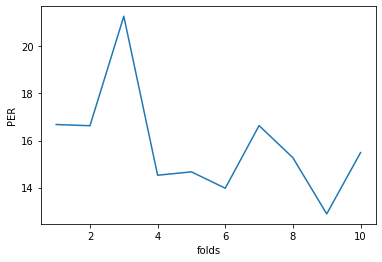

In [ ]:
plt.plot(np.arange(1,11), test_pers)
plt.xlabel("folds")
plt.ylabel("PER")

In [ ]:
test_pers

[16.680256771811873,
 16.630432365661633,
 21.278982138770576,
 14.527798147662663,
 14.670658797840163,
 13.975804435840262,
 16.63578164940222,
 15.270198536149643,
 12.884835015739338,
 15.488006724256383]

In [ ]:
np.mean(test_pers)

15.804275458313475

In [ ]:
np.std(test_pers)

2.1743936668924224

In [ ]:
np.mean(test_pers) + np.std(test_pers)

17.978669125205897